# Plots

## Imports

In [1]:
import sys
import os
import torch
import numpy as np
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)
from ssast_model import ASTModel
import soundfile as sf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchaudio
import pickle
import librosa

In [2]:
# Setting global parameters for Matplotlib to use LaTeX rendering
plt.rcParams.update({
    'text.usetex': True,  # Enable LaTeX rendering
    'text.latex.preamble': r'\usepackage{lmodern}',  # Use Latin Modern font
    'font.family': 'serif',  # Use serif font for consistency with LaTeX document
    'font.serif': ['Latin Modern Roman'],  # Specify Latin Modern Roman
    'pdf.fonttype': 42,  # Ensures fonts are embedded as TrueType
    'savefig.dpi': 400,  # Lower DPI setting for non-text elements
    'font.size': 12,  # Adjust font size to match document (you may need to tweak this)
    'axes.labelsize': 12,  # Size of the x and y labels
    'axes.titlesize': 14,  # Size of the plot title
    'xtick.labelsize': 10,  # Size of the x-axis tick labels
    'ytick.labelsize': 10,  # Size of the y-axis tick labels
    'legend.fontsize': 12,  # Size of the legend font
    'figure.titlesize': 16  # Size of the figure's main title if any
})

## Spectrogram

Time of last sample: 9.9999375
Number of samples: 160000
Sample rate: 16000
Duration of audio: 10.0
Shape of audio signal: (160000,)
Type of audio signal: <class 'numpy.ndarray'>
Data type of audio signal: float64
Type of audio tensor: <class 'torch.Tensor'>
Data type of audio tensor: torch.float64
Shape of audio tensor: torch.Size([160000])
Data type of audio tensor: torch.float32
Shape of audio tensor: torch.Size([1, 160000])
Shape of fbank features: torch.Size([998, 128])


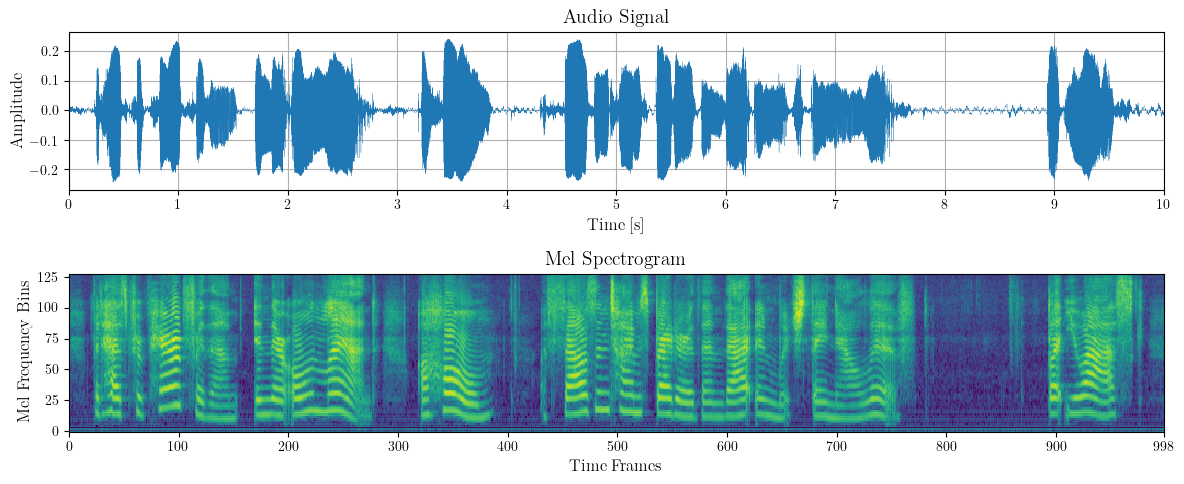

In [3]:
# Verify the file path is correct
file_path = '/home/bosfab01/SpeakerVerificationBA/data/preprocessed/0a4b5c0f-facc-4d3b-8a41-bc9148d62d95/0_segment_0.flac'
try:
    audio_signal, sample_rate = sf.read(file_path)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    raise

# Create time array for plotting
time = np.arange(len(audio_signal)) / sample_rate

# Print information about the audio
print("Time of last sample:", time[-1])
print("Number of samples:", len(audio_signal))
print("Sample rate:", sample_rate)
print("Duration of audio:", len(audio_signal) / sample_rate)
print("Shape of audio signal:", audio_signal.shape)
print("Type of audio signal:", type(audio_signal))
print("Data type of audio signal:", audio_signal.dtype)


# Convert the NumPy array to a PyTorch tensor
audio_tensor = torch.from_numpy(audio_signal)
print("Type of audio tensor:", type(audio_tensor))
print("Data type of audio tensor:", audio_tensor.dtype)
print("Shape of audio tensor:", audio_tensor.shape)

# Ensure the tensor is in float32 format (required for most torchaudio operations)
audio_tensor = audio_tensor.float()
print("Data type of audio tensor:", audio_tensor.dtype)

# If your array is not in batch x channels x time format, adjust accordingly
# Assuming the audio signal is single-channel and not batched:
audio_tensor = audio_tensor.unsqueeze(0)
print("Shape of audio tensor:", audio_tensor.shape)

# Now call the fbank function
fbank_features = torchaudio.compliance.kaldi.fbank(
    audio_tensor, 
    sample_frequency=sample_rate, 
    htk_compat=True, 
    use_energy=False, 
    window_type='hanning', 
    num_mel_bins=128, 
    dither=0.0, 
    frame_shift=10
)

# Output the shape of the fbank features to confirm
print(f"Shape of fbank features: {fbank_features.shape}")

# Function to plot spectrogram
def plot_spectrogram(spectrogram, ax, title="Mel Spectrogram"):
    # Assuming spectrogram data is on a tensor and needs to be moved to CPU and converted to numpy array
    ax.imshow(spectrogram.T.cpu().numpy(), aspect='auto', origin='lower', cmap='viridis', interpolation='none')
    ax.set_title(title)
    ax.set_xticks(np.concatenate((np.arange(0, 1000, 100), [spectrogram.shape[0]])))
    ax.set_yticks(np.arange(0, 150, 25))
    ax.set_xlabel('Time Frames')
    ax.set_ylabel('Mel Frequency Bins')

def plot_spectrogram_mesh(spectrogram, ax, title="Spectrogram"):
    # Convert tensor to numpy if necessary
    data = spectrogram.T.cpu().numpy()
    # Create a meshgrid for the x and y dimensions
    x = np.linspace(0, data.shape[1], data.shape[1])
    y = np.linspace(0, data.shape[0], data.shape[0])
    X, Y = np.meshgrid(x, y)
    # Use pcolormesh to plot data
    pcm = ax.pcolormesh(X, Y, data, shading='auto', cmap='viridis')
    ax.set_title(title)
    ax.set_xticks(np.concatenate((np.arange(0, 1000, 100), [spectrogram.shape[0]])))
    ax.set_yticks(np.arange(0, 150, 25))
    ax.set_xlabel('Time Frames')
    ax.set_ylabel('Mel Frequency Bins')
    # Optionally add a colorbar
    #plt.colorbar(pcm, ax=ax)

# Create a figure with two subplots, one above the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5))  # Adjust total figure size as needed

# Plot the audio signal
ax1.plot(time, audio_signal, linewidth=0.2)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Amplitude')
ax1.set_xticks(np.arange(0, 11, 1))
ax1.set_yticks(np.arange(-0.2, 0.3, 0.1))
ax1.set_xlim([0, 10])
ax1.set_title('Audio Signal')
ax1.grid(True)

# Plot the fbank features using the defined function
plot_spectrogram(fbank_features, ax2)

# Adjust layout so plots do not overlap
plt.tight_layout()

# Save the figure as a PDF file
directory = 'plots'
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig("plots/waveform_spectrogram.pdf")

# Show the figure
plt.show()

## Pretraining

### Loss

rows orig:	 193 ;		columns orig:	 7
rows gong:	 199 ;		columns gong:	 5


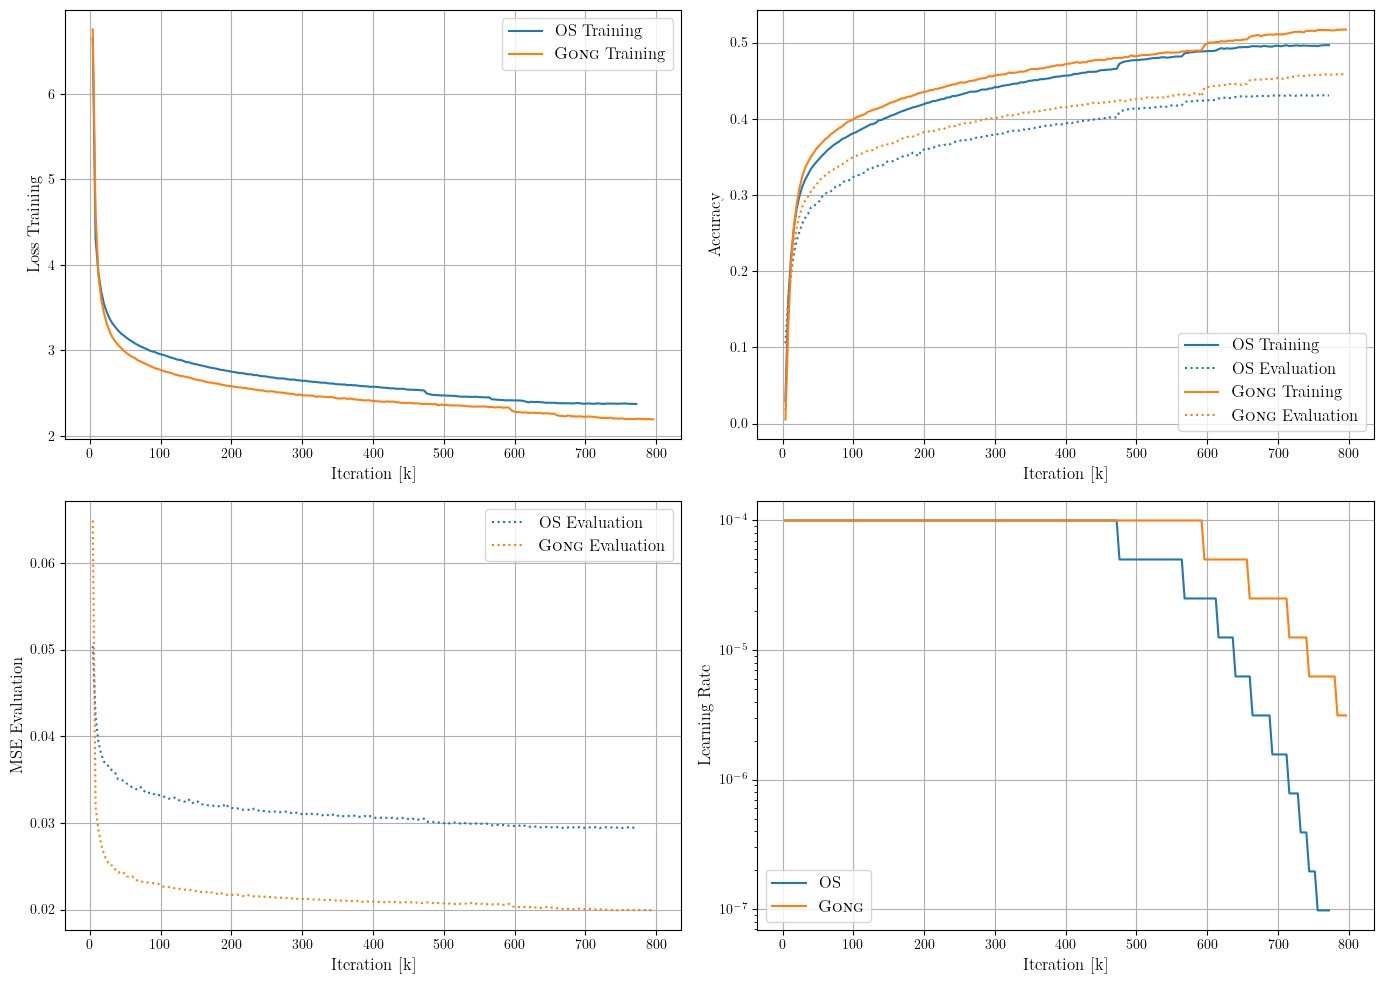

In [4]:
path_original = '/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240418-211014'
relative_path_gong = 'pretraining/result_gong.csv'
path_gong = os.path.join(parent_directory, relative_path_gong)

with open(os.path.join(path_original, 'progress.pkl'), 'rb') as f:
    progress_original = pickle.load(f)
iteration_original = np.array([x[1] for x in progress_original])

result_original = np.genfromtxt(os.path.join(path_original, 'result.csv'), delimiter=',')
result_gong = np.genfromtxt(path_gong, delimiter=',')
print("rows orig:\t", result_original.shape[0], ";\t\tcolumns orig:\t", result_original.shape[1])
print("rows gong:\t", result_gong.shape[0], ";\t\tcolumns gong:\t", result_gong.shape[1])

def get_column(array):
    for i in range(array.shape[1]):
        yield array[:, i]

acc_tr_original, loss1_tr_original, loss2_tr_original, acc_ev_original, loss1_ev_original, loss2_ev_original, lr_original = get_column(result_original)
acc_tr_gong, loss_tr_gong, acc_ev_gong, mse_ev_gong, lr_gong = get_column(result_gong)
iteration_gong = np.arange(1, len(acc_tr_gong)+1) * 4000

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

color_original = 'tab:blue'
color_gong = 'tab:orange'

axs[0, 0].plot(iteration_original/1e3, loss1_tr_original+10*loss2_tr_original, label='OS Training', color=color_original)
axs[0, 0].plot(iteration_gong/1e3, loss_tr_gong, label=r'\textsc{Gong} Training', color=color_gong)
#axs[0, 0].set_title('Loss Training')
axs[0, 0].set_xticks(np.arange(0, 900, 100))
#axs[0, 0].set_yticks(np.arange(np.min(loss1_tr_original+10*loss2_tr_original), np.max(loss1_tr_original+10*loss2_tr_original), 0.5))
axs[0, 0].set_xlabel('Iteration [k]')
axs[0, 0].set_ylabel('Loss Training')
axs[0, 0].legend()
axs[0, 0].grid()

axs[0, 1].plot(iteration_original/1e3, acc_tr_original, label='OS Training', color=color_original)
axs[0, 1].plot(iteration_original/1e3, acc_ev_original, label='OS Evaluation', color=color_original, linestyle='dotted')
axs[0, 1].plot(iteration_gong/1e3, acc_tr_gong, label=r'\textsc{Gong} Training', color=color_gong)
axs[0, 1].plot(iteration_gong/1e3, acc_ev_gong, label=r'\textsc{Gong} Evaluation', color=color_gong, linestyle='dotted')
#axs[0, 1].set_title('Accuracy')
axs[0, 1].set_xticks(np.arange(0, 900, 100))       
axs[0, 1].set_xlabel('Iteration [k]')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 0].plot(iteration_original/1e3, loss2_ev_original, label='OS Evaluation', color=color_original, linestyle='dotted')
axs[1, 0].plot(iteration_gong/1e3, mse_ev_gong, label=r'\textsc{Gong} Evaluation', color=color_gong, linestyle='dotted')
#axs[1, 0].set_title('MSE Evaluation')
axs[1, 0].set_xticks(np.arange(0, 900, 100))
axs[1, 0].set_xlabel('Iteration [k]')
axs[1, 0].set_ylabel('MSE Evaluation')
axs[1, 0].legend()
axs[1, 0].grid()

axs[1, 1].plot(iteration_original/1e3, lr_original, label='OS', color=color_original)
axs[1, 1].plot(iteration_gong/1e3, lr_gong, label=r'\textsc{Gong}', color=color_gong)
#axs[1, 1].set_title('Learning Rate')
axs[1, 1].set_xticks(np.arange(0, 900, 100))
axs[1, 1].set_xlabel('Iteration [k]')
axs[1, 1].set_ylabel('Learning Rate ')
axs[1, 1].set_yscale('log')
axs[1, 1].legend(loc='lower left')
axs[1, 1].grid()

plt.tight_layout()

directory = 'plots'
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig('plots/training_progress.pdf')

plt.show()

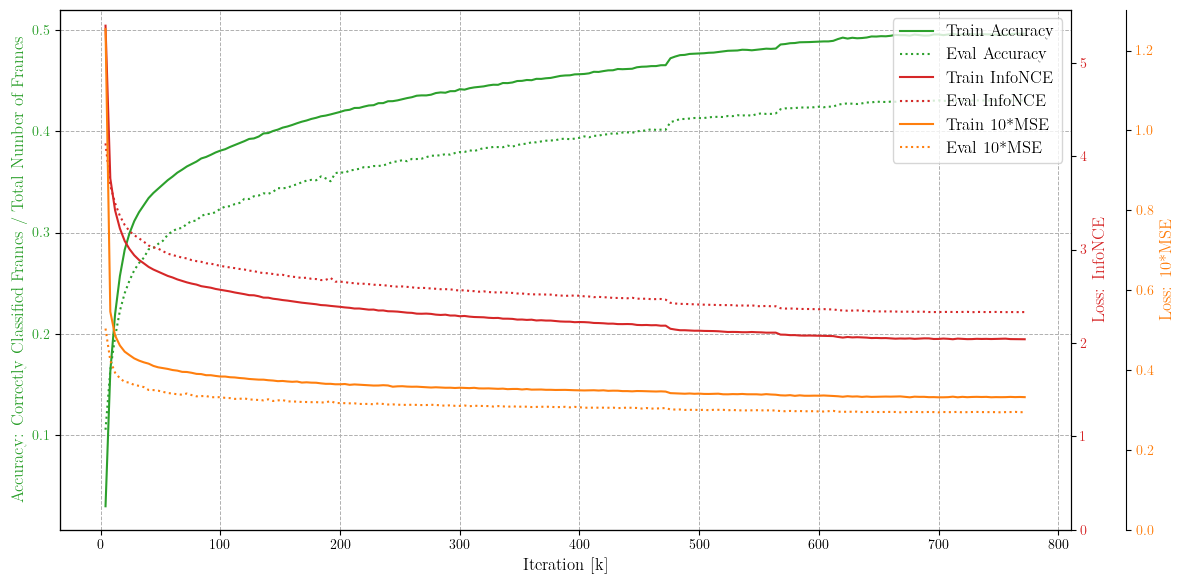

In [5]:
# Visualize the training progress
fig, ax1 = plt.subplots(figsize=(12, 6))

# set title
#fig.suptitle('Pretraining Progress')

color_acc = 'tab:green'
ax1.set_xlabel('Iteration [k]')
ax1.set_ylabel('Accuracy: Correctly Classified Frames / Total Number of Frames', color=color_acc)
line1, = ax1.plot(iteration_original / 1e3, acc_tr_original, color=color_acc, label='Train Accuracy')
line2, = ax1.plot(iteration_original / 1e3, acc_ev_original, color=color_acc, linestyle='dotted', label='Eval Accuracy')
ax1.tick_params(axis='y', labelcolor=color_acc)
#ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
color_InfoNCE = 'tab:red'
ax2.set_ylabel('Loss: InfoNCE', color=color_InfoNCE)
line3, = ax2.plot(iteration_original / 1e3, loss1_tr_original, color=color_InfoNCE, label='Train InfoNCE')
line4, = ax2.plot(iteration_original / 1e3, loss1_ev_original, color=color_InfoNCE, linestyle='dotted', label='Eval InfoNCE')
ax2.tick_params(axis='y', labelcolor=color_InfoNCE)
ax2.set_ylim(0, ax2.get_ylim()[1])

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 40))
color_10MSE = 'tab:orange'
ax3.set_ylabel('Loss: 10*MSE', color=color_10MSE)
line5, = ax3.plot(iteration_original / 1e3, loss2_tr_original*10, color=color_10MSE, label='Train 10*MSE')
line6, = ax3.plot(iteration_original / 1e3, loss2_ev_original*10, color=color_10MSE, linestyle='dotted', label='Eval 10*MSE')
ax3.tick_params(axis='y', labelcolor=color_10MSE)
ax3.set_ylim(0, ax3.get_ylim()[1])

# Adding grid to the primary axis (ax1)
ax1.grid(True, which='both', linestyle='--', linewidth=0.7)

# Collect all lines and labels for the legend
lines = [line1, line2, line3, line4, line5, line6]
labels = [line.get_label() for line in lines]

# After your plotting code, to adjust the legend:
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)

# Place a single legend on the plot
ax3.legend(lines, labels, loc='best')

plt.tight_layout()


directory = 'plots'
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig('plots/pretraining_progress.pdf')

plt.show()

### visualize the masked spectrogram, the reconstructed spectrogram, and the original spectrogram

Time of last sample: 9.9999375
Number of samples: 160000
Sample rate: 16000
Duration of audio: 10.0
Shape of audio signal: (160000,)
Type of audio signal: <class 'numpy.ndarray'>
Data type of audio signal: float64
Type of audio tensor: <class 'torch.Tensor'>
Data type of audio tensor: torch.float64
Shape of audio tensor: torch.Size([160000])
Data type of audio tensor: torch.float32
Shape of audio tensor: torch.Size([1, 160000])
Shape of fbank features: torch.Size([998, 128])
Shape of fbank features: torch.Size([1, 998, 128])
pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=499
pretraining number of patches=499
cpu
range(50, 489, 50)
[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156

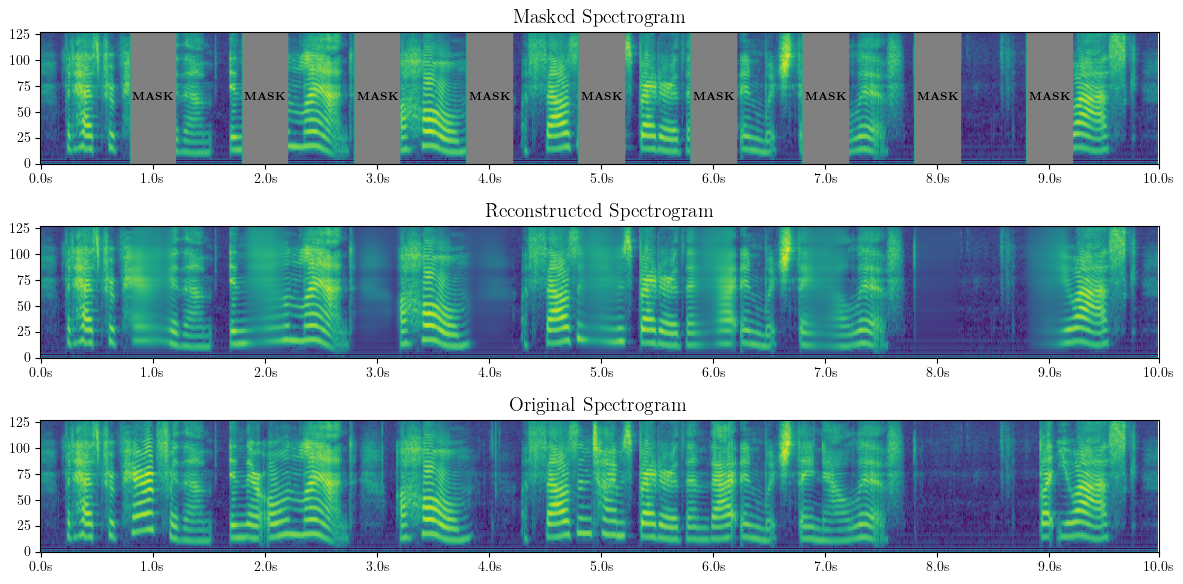

In [6]:
# Verify the file path is correct
file_path = '/home/bosfab01/SpeakerVerificationBA/data/preprocessed/0a4b5c0f-facc-4d3b-8a41-bc9148d62d95/0_segment_0.flac'
try:
    audio_signal, sample_rate = sf.read(file_path)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    raise

# Create time array for plotting
time = np.arange(len(audio_signal)) / sample_rate

# Print information about the audio
print("Time of last sample:", time[-1])
print("Number of samples:", len(audio_signal))
print("Sample rate:", sample_rate)
print("Duration of audio:", len(audio_signal) / sample_rate)
print("Shape of audio signal:", audio_signal.shape)
print("Type of audio signal:", type(audio_signal))
print("Data type of audio signal:", audio_signal.dtype)


# Convert the NumPy array to a PyTorch tensor
audio_tensor = torch.from_numpy(audio_signal)
print("Type of audio tensor:", type(audio_tensor))
print("Data type of audio tensor:", audio_tensor.dtype)
print("Shape of audio tensor:", audio_tensor.shape)

# Ensure the tensor is in float32 format (required for most torchaudio operations)
audio_tensor = audio_tensor.float()
print("Data type of audio tensor:", audio_tensor.dtype)

# If your array is not in batch x channels x time format, adjust accordingly
# Assuming the audio signal is single-channel and not batched:
audio_tensor = audio_tensor.unsqueeze(0)
print("Shape of audio tensor:", audio_tensor.shape)

# Now call the fbank function
fbank_features = torchaudio.compliance.kaldi.fbank(
    audio_tensor, 
    sample_frequency=sample_rate, 
    htk_compat=True, 
    use_energy=False, 
    window_type='hanning', 
    num_mel_bins=128, 
    dither=0.0, 
    frame_shift=10
)

# Output the shape of the fbank features to confirm
print(f"Shape of fbank features: {fbank_features.shape}")
test_input = fbank_features

# normalize fbank features
dataset_mean=-3.6925695
dataset_std=4.020388
test_input = (test_input - dataset_mean) / (2 * dataset_std)

# add batch dimension
test_input = test_input.unsqueeze(0)
print(f"Shape of fbank features: {test_input.shape}")

# # duplicate input tensor to get a batch of 2
# test_input = torch.cat((test_input, test_input), 0)
# print(f"Shape of dublicated fbank features: {test_input.shape}")



model = ASTModel(fshape=128, tshape=2, fstride=128, tstride=2, input_fdim=128, input_tdim=998, model_size='base', pretrain_stage=True)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load('/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240418-211014/models/audio_model.194.pth'))
model = model.module
model.to('cpu')
model.eval()
print(next(model.parameters()).device)  # Should print 'cpu'



hop_width = 20
hop_length = 50 # just for visualization, not the actual hop length used in the data preparation
hops = range(hop_length, 998//2 - hop_width//2, hop_length)
print(hops)
mask_indices = [range(i-hop_width//2, i + hop_width//2) for i in hops]
mask_indices = [idx for group in mask_indices for idx in group]
print(mask_indices)

# turn indices from model basis [0, 499] to spectrogram basis [0, 998]
expanded_mask_indices = []
for idx in mask_indices:
    expanded_mask_indices.extend([2 * idx, 2 * idx + 1])  # Expanding indice

# Create a mask for the spectrogram
mask = torch.ones_like(test_input)
for idx in expanded_mask_indices:
    mask[0, idx, :] = 0  # Set the specific patches to 0

# Apply the mask to the input spectrogram
masked_spectrogram = test_input * mask

# turn into tensor
mask_indices = torch.tensor(mask_indices)

# Call the model
with torch.no_grad():
    reconstructed_spectrogram = model(test_input, task='visualize_mask', mask_indices=mask_indices)

# compare input and output
print(test_input.shape)
print(reconstructed_spectrogram.shape)

# Assuming 'test_input' is your spectrogram tensor
n_timesteps = test_input.shape[1]  # 998
time_per_step = 10 / 1000  # Example: if each step represents 10 ms (adjust based on your actual data setup)

# Creating time labels for every 100 steps (1 second if each step is 10 ms)
# round timesteps to next 100 and get the range
x_ticks = np.arange(0, n_timesteps, 100)
last_tick = int(np.ceil(n_timesteps / 100) * 100)
x_ticks = np.append(x_ticks, last_tick)
 # formatting time labels as strings in seconds
x_labels = [f"{x * time_per_step:.1f}s" for x in x_ticks]
x_ticks[-1] = n_timesteps

print("x_ticks:", x_ticks)
print("x_labels:", x_labels)


# y-ticks for the frequency axis
y_ticks = np.arange(0, 128, 25)

# Now plotting all three: original input, masked input, and reconstructed output
plt.figure(figsize=(12, 6))

# Define the patch width and height
patch_height = test_input.shape[2]  # This is the vertical height of your spectrogram

# Function to add rectangles to the axes
def add_rectangles(ax, hops, patch_width, patch_height):
    for mid_index in hops:
        # Calculate the left corner of the rectangle
        left_corner = 2*mid_index - patch_width
        # Create a rectangle patch with gray color
        rect = patches.Rectangle((left_corner, 0), 2*patch_width, patch_height, linewidth=1, edgecolor='gray', facecolor='gray')  # semi-transparent
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        # Add 'MASK' text at the center of the rectangle
        ax.text(left_corner + patch_width, patch_height / 2, r'\textbf{MASK}', horizontalalignment='center', verticalalignment='center', color='black', fontsize=8)


ax1 = plt.subplot(3, 1, 1)
plt.imshow(masked_spectrogram[0].cpu().numpy().T, aspect='auto', origin='lower')
add_rectangles(ax1, hops, hop_width, patch_height)
plt.title('Masked Spectrogram')
plt.xticks(x_ticks, x_labels)
plt.yticks(y_ticks)

ax2 = plt.subplot(3, 1, 2)
plt.imshow(reconstructed_spectrogram[0].cpu().numpy().T, aspect='auto', origin='lower')
plt.title('Reconstructed Spectrogram')
plt.xticks(x_ticks, x_labels)
plt.yticks(y_ticks)

ax3 = plt.subplot(3, 1, 3)
plt.imshow(test_input[0].cpu().numpy().T, aspect='auto', origin='lower')
plt.title('Original Spectrogram')
plt.xticks(x_ticks, x_labels) 
plt.yticks(y_ticks)

plt.tight_layout()


directory = 'plots'
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig('plots/reconstructed_spectrogram_speech.pdf')

plt.show()

### visualize the reconstruction at various stages of the training process

[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459]


pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=499
pretraining number of patches=499
pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=499
pretraining number of patches=499
pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=499
pretraining number of patches=499
pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=499
pretraining number of patches=499
pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=499
pretraining number of patches=499
input shape:  torch.Size([1, 1, 128, 998

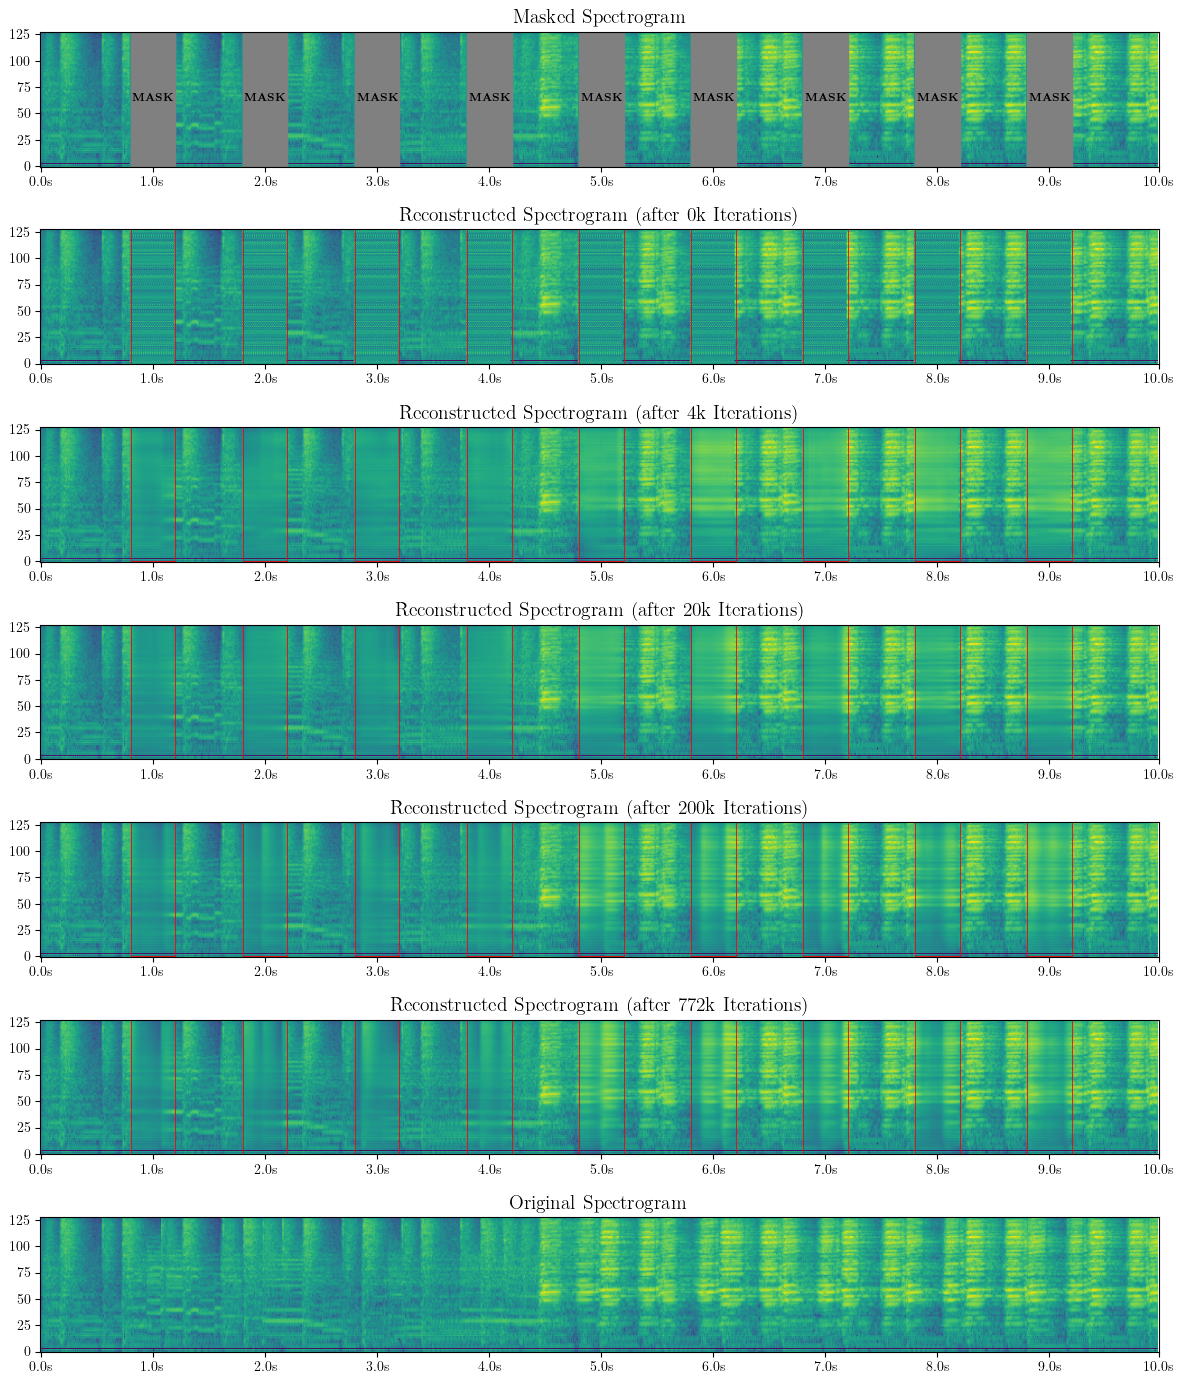

In [7]:
# Verify the file path is correct
#file_path = '/home/bosfab01/SpeakerVerificationBA/data/preprocessed/0a4b5c0f-facc-4d3b-8a41-bc9148d62d95/0_segment_0.flac'
file_path = '/home/bosfab01/SpeakerVerificationBA/data/preprocessed_eval/1a281f7d-bde7-4744-9220-7ea599b6e093/0_segment_0.flac'
try:
    audio_signal, sample_rate = sf.read(file_path)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    raise

# Create time array for plotting
time = np.arange(len(audio_signal)) / sample_rate

# Convert the NumPy array to a PyTorch tensor
audio_tensor = torch.from_numpy(audio_signal)

# Ensure the tensor is in float32 format (required for most torchaudio operations)
audio_tensor = audio_tensor.float()

# If your array is not in batch x channels x time format, adjust accordingly
# Assuming the audio signal is single-channel and not batched:
audio_tensor = audio_tensor.unsqueeze(0)

# Now call the fbank function
fbank_features = torchaudio.compliance.kaldi.fbank(
    audio_tensor, 
    sample_frequency=sample_rate, 
    htk_compat=True, 
    use_energy=False, 
    window_type='hanning', 
    num_mel_bins=128, 
    dither=0.0, 
    frame_shift=10
)

# Output the shape of the fbank features to confirm
test_input = fbank_features

# normalize fbank features
dataset_mean=-3.6925695
dataset_std=4.020388
test_input = (test_input - dataset_mean) / (2 * dataset_std)

# add batch dimension
test_input = test_input.unsqueeze(0)

width = 20
hop_length = 50 # just for visualization, not the actual hop length used in the data preparation
hops = range(hop_length, 998//2 - width//2, hop_length)
mask_indices = [range(i-width//2, i + width//2) for i in hops]
mask_indices = [idx for group in mask_indices for idx in group]
print(mask_indices)

# turn indices from model basis [0, 499] to spectrogram basis [0, 998]
expanded_mask_indices = []
for idx in mask_indices:
    expanded_mask_indices.extend([2 * idx, 2 * idx + 1])  # Expanding indice

# Create a mask for the spectrogram
mask = torch.ones_like(test_input)
for idx in expanded_mask_indices:
    mask[0, idx, :] = 0  # Set the specific patches to 0

# Apply the mask to the input spectrogram
masked_spectrogram = test_input * mask

# turn into tensor
mask_indices = torch.tensor(mask_indices)

# Assuming 'test_input' is your spectrogram tensor
n_timesteps = test_input.shape[1]  # 998
time_per_step = 10 / 1000  # Example: if each step represents 10 ms (adjust based on your actual data setup)

# Creating time labels for every 100 steps (1 second if each step is 10 ms)
# round timesteps to next 100 and get the range
x_ticks = np.arange(0, n_timesteps, 100)
last_tick = int(np.ceil(n_timesteps / 100) * 100)
x_ticks = np.append(x_ticks, last_tick)
 # formatting time labels as strings in seconds
x_labels = [f"{x * time_per_step:.1f}s" for x in x_ticks]
x_ticks[-1] = n_timesteps


# y-ticks for the frequency axis
y_ticks = np.arange(0, 128, 25)


def initialize_model():
    return ASTModel(fshape=128, tshape=2, fstride=128, tstride=2, input_fdim=128, input_tdim=998, model_size='base', pretrain_stage=True)

def load_model(checkpoint_id):
    model = initialize_model()
    model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(f'/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240418-211014/models/audio_model.{checkpoint_id}.pth'))
    model = model.module
    model.to('cpu')
    model.eval()
    return model

# Load models
models = {i: load_model(i) for i in [1, 2, 6, 51, 194]}

# Generate spectrograms
with torch.no_grad():
    reconstructed_spectrograms = {i: model(test_input, task='visualize_mask', mask_indices=mask_indices) for i, model in models.items()}

# Plotting
plt.figure(figsize=(12, 14))

def plot_spectrogram(data, title, position):         
    plt.subplot(7, 1, position)
    plt.imshow(data[0].cpu().numpy().T, aspect='auto', origin='lower')
    plt.title(title)
    plt.xticks(x_ticks, x_labels)
    plt.yticks(y_ticks)
    #plt.xlabel('Time')
    #plt.ylabel('Mel Frequency Bins')

def add_red_rectangles(ax, hops, patch_width, patch_height):
    for mid_index in hops:
        # Calculate the left corner of the rectangle
        left_corner = 2*mid_index - patch_width
        # Create a rectangle with no fill
        rect = patches.Rectangle((left_corner, 0), 2*patch_width, patch_height, linewidth=0.6, edgecolor='red', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

def add_gray_mask(ax, hops, patch_width, patch_height):
    for mid_index in hops:
        # Calculate the left corner of the rectangle
        left_corner = 2*mid_index - patch_width
        # Create a rectangle patch with gray color
        rect = patches.Rectangle((left_corner, 0), 2*patch_width, patch_height, linewidth=1, edgecolor='gray', facecolor='gray')  # semi-transparent
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        # Add 'MASK' text at the center of the rectangle
        ax.text(left_corner + patch_width, patch_height / 2, r'\textbf{MASK}', horizontalalignment='center', verticalalignment='center', color='black', fontsize=8)


# masked spectrogram
plot_spectrogram(masked_spectrogram, 'Masked Spectrogram', 1)
add_gray_mask(plt.gca(), hops, width, test_input.shape[2])

# reconstructed spectrograms
for index, checkpoint in enumerate(sorted(reconstructed_spectrograms.keys())):
    plot_spectrogram(reconstructed_spectrograms[checkpoint], f'Reconstructed Spectrogram (after {(checkpoint-1)*4}k Iterations)', index + 2)
    add_red_rectangles(plt.gca(), hops, width, test_input.shape[2])

# original spectrogram
plot_spectrogram(test_input, 'Original Spectrogram', 7)
#add_red_rectangles(plt.gca(), hops, width, test_input.shape[2])

plt.tight_layout()

directory = 'plots'
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig('plots/reconstructed_spectrogram_music.pdf')

plt.show()